# 스마트 퍼스널 트레이너
# 딥러닝(CNN)을 활용한 스쿼트 운동 자세 자동 교정 프로젝트
## 2조 박현재 정재욱 김원수 함재욱 최윤영

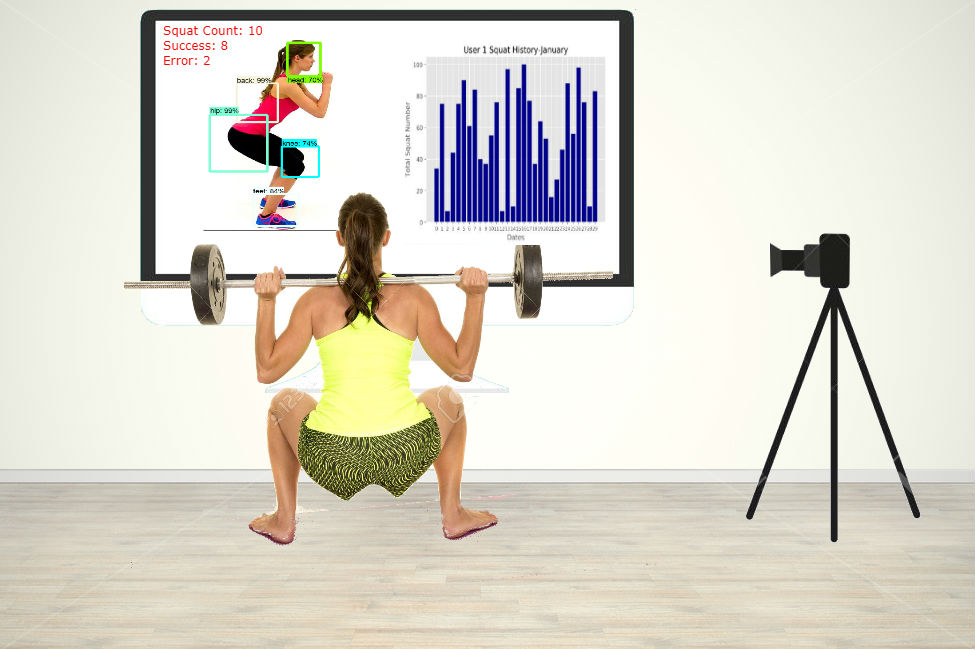

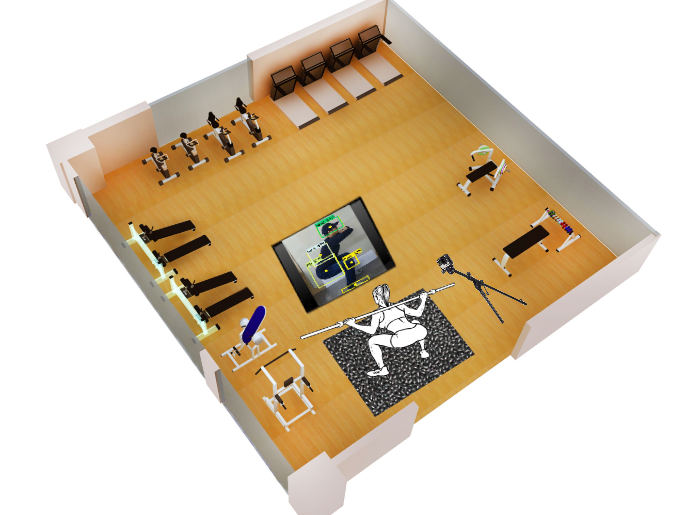

# 목차
##     1. 딥러닝 학습
##     2. 스쿼트 자세 판별
##     3. MQTT 활용
##     4. SQL/DB 활용
##     5. 개선점

# 1. 딥러닝 학습

## 1-1) 이미지 확보

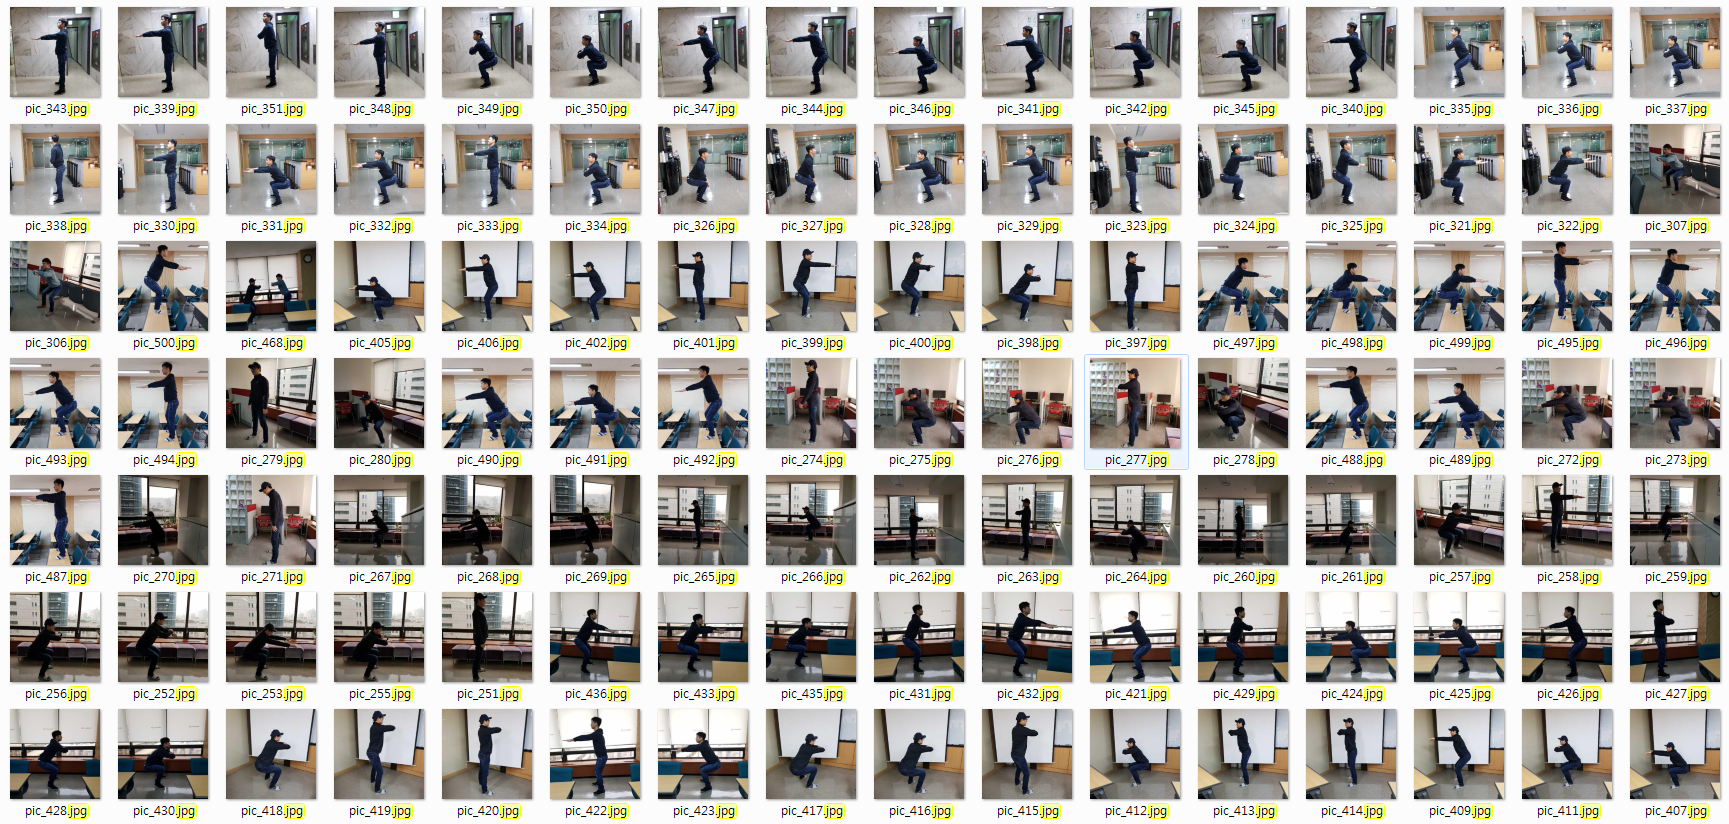

### 직접 촬영 / Google Image 활용하여 약 500장 확보

## 1- 2) Labeling 작업

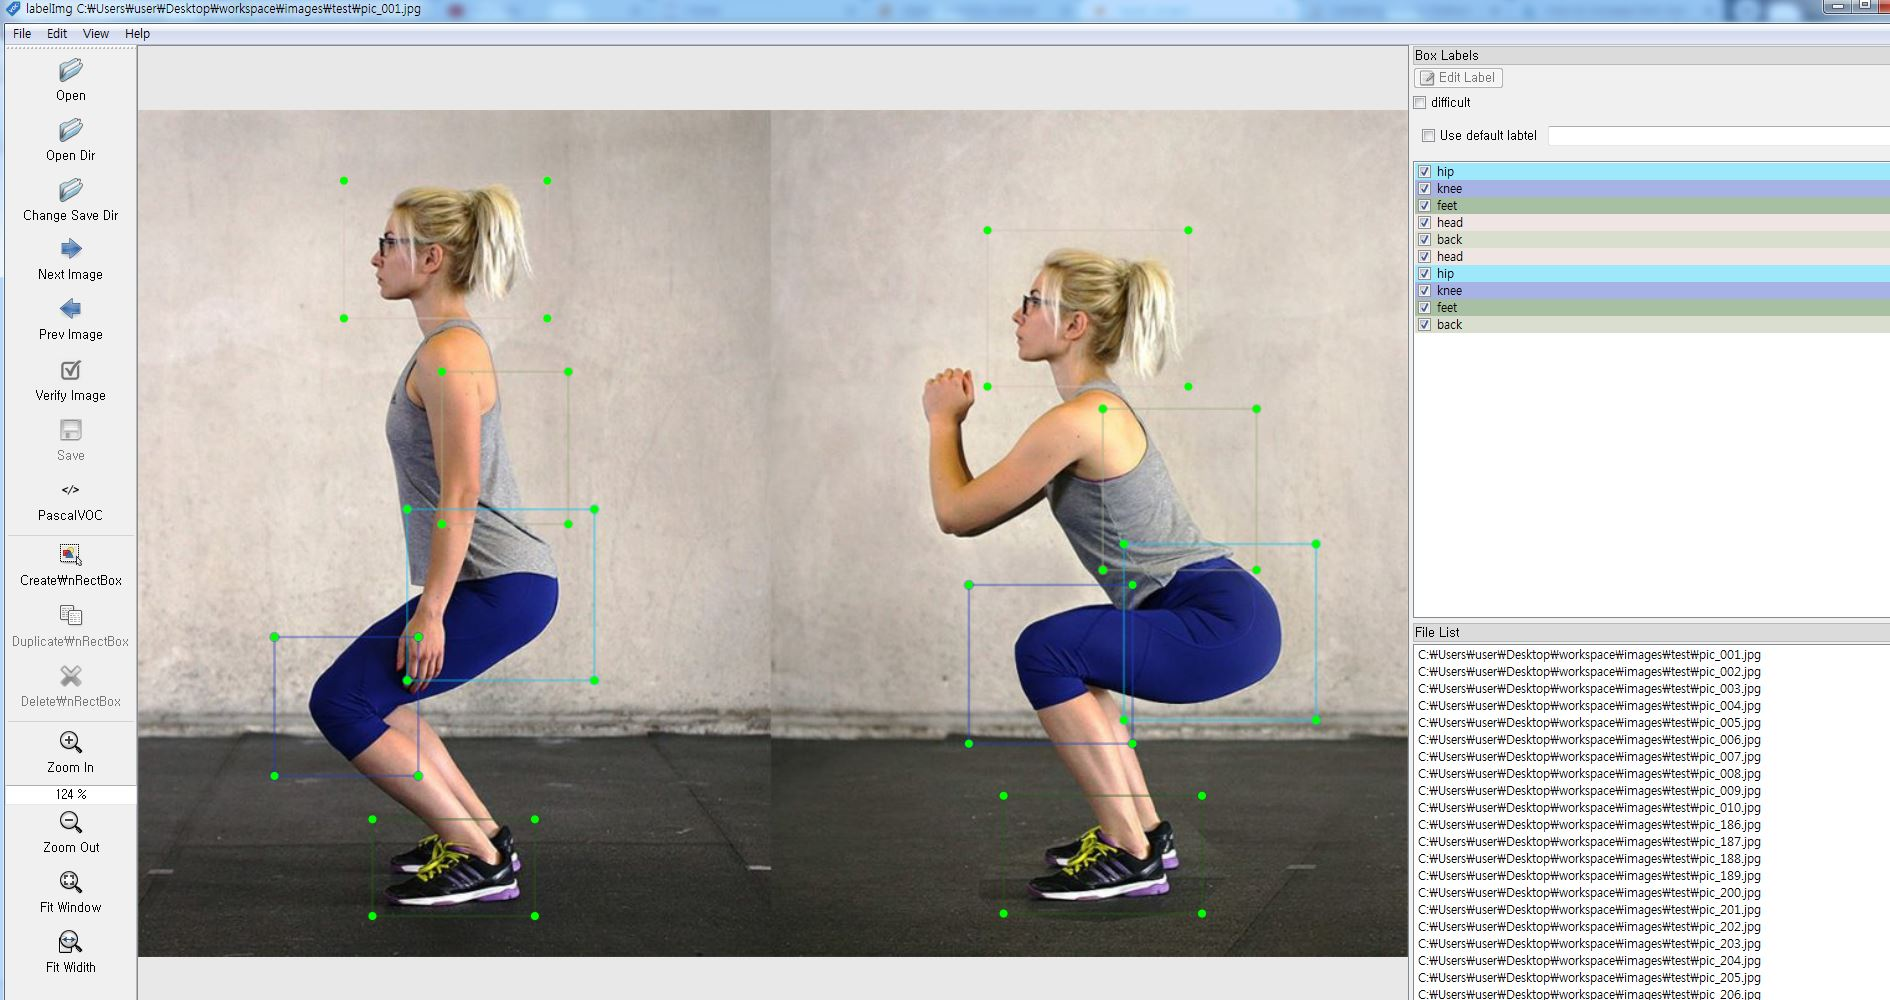

### Labeling 프로그램 활용하여 머리, 등, 엉덩이, 무릎, 발 레이블링 => XML 파일로 저장

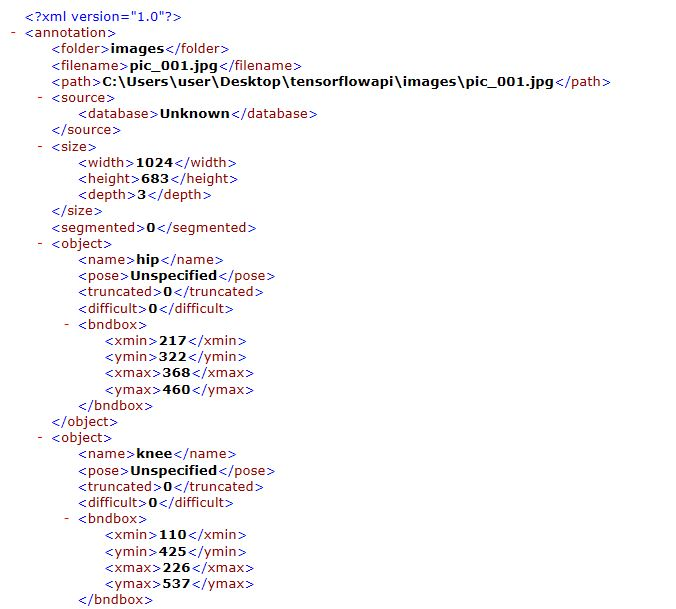

## 1-3) TF Record 생성
### Tensorflow Object Detection API를 사용하기 위하여 XML파일 TF Record 로 변환

In [ ]:
# XML => CSV 변환코드
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

####################################################################################
def main():
    for directory in ["train","test"]:
        image_path = os.path.join(os.getcwd(), 'images/{}'.format(directory))
        xml_df = xml_to_csv(image_path)
        xml_df.to_csv('data/{}_labels.csv'.format(directory), index=None)
        print('Successfully converted xml to csv.')
####################################################################################

main()

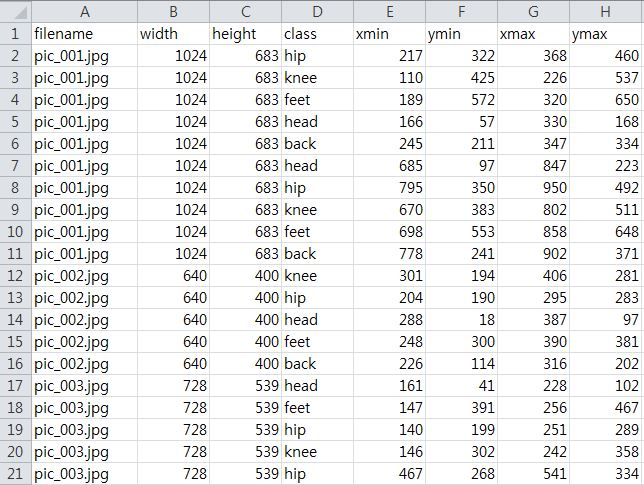

In [ ]:
# CSV => TF Record 변환 코드
"""
Usage:
  # From tensorflow/models/
  # Create train data:
  python generate_tfrecord.py --csv_input=data/train_labels.csv  --output_path=data/train.record --image_dir=images/train

  # Create test data:
  python generate_tfrecord.py --csv_input=data/test_labels.csv  --output_path=data/test.record --image_dir=images/test
"""
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

flags = tf.app.flags
flags.DEFINE_string('csv_input', '', 'Path to the CSV input')
flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
flags.DEFINE_string('image_dir', '', 'Path to images')
FLAGS = flags.FLAGS

####################################################################################
# TO-DO replace this with label map
def class_text_to_int(row_label):
    if row_label == 'head':
        return 1
    if row_label == 'knee':
        return 2
    if row_label == 'hip':
        return 3
    if row_label == 'feet':
        return 4
    if row_label == 'back':
        return 5
    else:
        None
####################################################################################

def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def main(_):
    writer = tf.python_io.TFRecordWriter(FLAGS.output_path)
    path = os.path.join(FLAGS.image_dir)
    examples = pd.read_csv(FLAGS.csv_input)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), FLAGS.output_path)
    print('Successfully created the TFRecords: {}'.format(output_path))


if __name__ == '__main__':
    tf.app.run()

## 1-4) Training
### 학습에 사용할 모델 지정 (SSD_Mobilenet_COCO)
### 데이터에 맞게 Config 파일을 통해 Parameter 변환

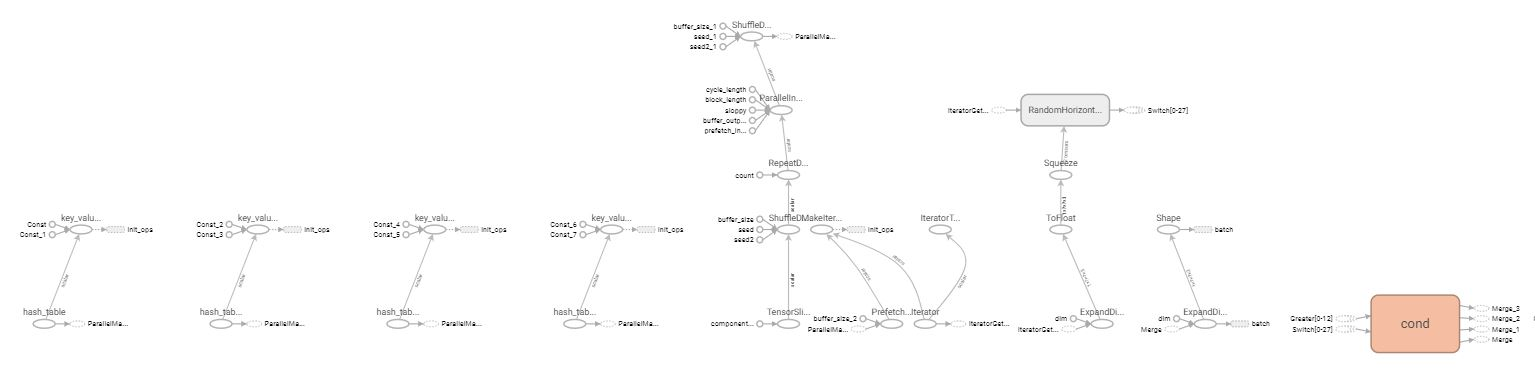
Tensorboard를 통해 확인한 COCO 학습 모델 앞부분

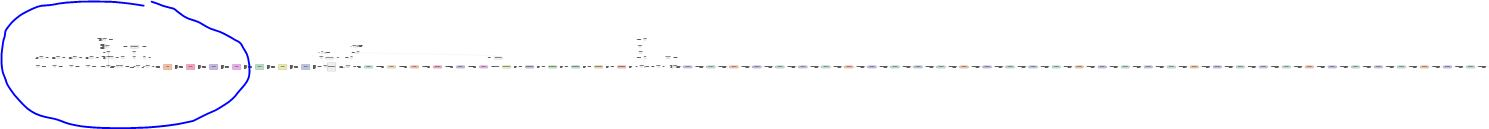

### Configuration 코드

In [ ]:
# SSD with Mobilenet v1, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 5 #####################
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.3333
      }
    }
    image_resizer {
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    box_predictor {
      convolutional_box_predictor {
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        use_dropout: false
        dropout_keep_probability: 0.8
        kernel_size: 1
        box_code_size: 4
        apply_sigmoid_to_scores: false
        conv_hyperparams {
          activation: RELU_6,
          regularizer {
            l2_regularizer {
              weight: 0.00004
            }
          }
          initializer {
            truncated_normal_initializer {
              stddev: 0.03
              mean: 0.0
            }
          }
          batch_norm {
            train: true,
            scale: true,
            center: true,
            decay: 0.9997,
            epsilon: 0.001,
          }
        }
      }
    }
    feature_extractor {
      type: 'ssd_mobilenet_v1'
      min_depth: 16  
      depth_multiplier: 1.0
      conv_hyperparams {
        activation: RELU_6,
        regularizer {
          l2_regularizer {
            weight: 0.00004
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          train: true,
          scale: true,
          center: true,
          decay: 0.9997,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid {
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      hard_example_miner {
        num_hard_examples: 3000
        iou_threshold: 0.99
        loss_type: CLASSIFICATION
        max_negatives_per_positive: 3
        min_negatives_per_image: 0
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  batch_size: 12  #####################
  optimizer {
    rms_prop_optimizer: {
      learning_rate: {
        exponential_decay_learning_rate {
          initial_learning_rate: 0.004
          decay_steps: 800720
          decay_factor: 0.95
        }
      }
      momentum_optimizer_value: 0.9
      decay: 0.9
      epsilon: 1.0
    }
  }
  fine_tune_checkpoint: "ssd_mobilenet_v1_coco_2017_11_17/model.ckpt"   #####################
  from_detection_checkpoint: true
  load_all_detection_checkpoint_vars: true
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 200000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }
}

train_input_reader: {
  tf_record_input_reader {
    input_path: "data/train.record"
  }
  label_map_path: "data/object-detection.pbtxt"
}

eval_config: {
  metrics_set: "coco_detection_metrics"
  num_examples: 1100
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "data/test.record"
  }
  label_map_path: "data/object-detection.pbtxt"
  shuffle: false
  num_readers: 1
}

### 학습 코드
### Tensorflow object detection API 사용

In [ ]:
# Copyright 2017 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

r"""Training executable for detection models.

This executable is used to train DetectionModels. There are two ways of
configuring the training job:

1) A single pipeline_pb2.TrainEvalPipelineConfig configuration file
can be specified by --pipeline_config_path.

Example usage:
    ./train \
        --logtostderr \
        --train_dir=path/to/train_dir \
        --pipeline_config_path=pipeline_config.pbtxt

2) Three configuration files can be provided: a model_pb2.DetectionModel
configuration file to define what type of DetectionModel is being trained, an
input_reader_pb2.InputReader file to specify what training data will be used and
a train_pb2.TrainConfig file to configure training parameters.
############################################################################################################################
Example usage:
    ./train \
        --logtostderr \
        --train_dir=path/to/train_dir \
        --model_config_path=model_config.pbtxt \
        --train_config_path=train_config.pbtxt \
        --input_config_path=train_input_config.pbtxt
############################################################################################################################        
"""

import functools
import json
import os
import tensorflow as tf

from object_detection.builders import dataset_builder
from object_detection.builders import graph_rewriter_builder
from object_detection.builders import model_builder
from object_detection.legacy import trainer
from object_detection.utils import config_util

tf.logging.set_verbosity(tf.logging.INFO)

flags = tf.app.flags
flags.DEFINE_string('master', '', 'Name of the TensorFlow master to use.')
flags.DEFINE_integer('task', 0, 'task id')
flags.DEFINE_integer('num_clones', 1, 'Number of clones to deploy per worker.')
flags.DEFINE_boolean('clone_on_cpu', False,
                     'Force clones to be deployed on CPU.  Note that even if '
                     'set to False (allowing ops to run on gpu), some ops may '
                     'still be run on the CPU if they have no GPU kernel.')
flags.DEFINE_integer('worker_replicas', 1, 'Number of worker+trainer '
                     'replicas.')
flags.DEFINE_integer('ps_tasks', 0,
                     'Number of parameter server tasks. If None, does not use '
                     'a parameter server.')
flags.DEFINE_string('train_dir', '',
                    'Directory to save the checkpoints and training summaries.')

flags.DEFINE_string('pipeline_config_path', '',
                    'Path to a pipeline_pb2.TrainEvalPipelineConfig config '
                    'file. If provided, other configs are ignored')

flags.DEFINE_string('train_config_path', '',
                    'Path to a train_pb2.TrainConfig config file.')
flags.DEFINE_string('input_config_path', '',
                    'Path to an input_reader_pb2.InputReader config file.')
flags.DEFINE_string('model_config_path', '',
                    'Path to a model_pb2.DetectionModel config file.')

FLAGS = flags.FLAGS


@tf.contrib.framework.deprecated(None, 'Use object_detection/model_main.py.')
def main(_):
  assert FLAGS.train_dir, '`train_dir` is missing.'
  if FLAGS.task == 0: tf.gfile.MakeDirs(FLAGS.train_dir)
  if FLAGS.pipeline_config_path:
    configs = config_util.get_configs_from_pipeline_file(
        FLAGS.pipeline_config_path)
    if FLAGS.task == 0:
      tf.gfile.Copy(FLAGS.pipeline_config_path,
                    os.path.join(FLAGS.train_dir, 'pipeline.config'),
                    overwrite=True)
  else:
    configs = config_util.get_configs_from_multiple_files(
        model_config_path=FLAGS.model_config_path,
        train_config_path=FLAGS.train_config_path,
        train_input_config_path=FLAGS.input_config_path)
    if FLAGS.task == 0:
      for name, config in [('model.config', FLAGS.model_config_path),
                           ('train.config', FLAGS.train_config_path),
                           ('input.config', FLAGS.input_config_path)]:
        tf.gfile.Copy(config, os.path.join(FLAGS.train_dir, name),
                      overwrite=True)

  model_config = configs['model']
  train_config = configs['train_config']
  input_config = configs['train_input_config']

  model_fn = functools.partial(
      model_builder.build,
      model_config=model_config,
      is_training=True)

  def get_next(config):
    return dataset_builder.make_initializable_iterator(
        dataset_builder.build(config)).get_next()

  create_input_dict_fn = functools.partial(get_next, input_config)

  env = json.loads(os.environ.get('TF_CONFIG', '{}'))
  cluster_data = env.get('cluster', None)
  cluster = tf.train.ClusterSpec(cluster_data) if cluster_data else None
  task_data = env.get('task', None) or {'type': 'master', 'index': 0}
  task_info = type('TaskSpec', (object,), task_data)

  # Parameters for a single worker.
  ps_tasks = 0
  worker_replicas = 1
  worker_job_name = 'lonely_worker'
  task = 0
  is_chief = True
  master = ''

  if cluster_data and 'worker' in cluster_data:
    # Number of total worker replicas include "worker"s and the "master".
    worker_replicas = len(cluster_data['worker']) + 1
  if cluster_data and 'ps' in cluster_data:
    ps_tasks = len(cluster_data['ps'])

  if worker_replicas > 1 and ps_tasks < 1:
    raise ValueError('At least 1 ps task is needed for distributed training.')

  if worker_replicas >= 1 and ps_tasks > 0:
    # Set up distributed training.
    server = tf.train.Server(tf.train.ClusterSpec(cluster), protocol='grpc',
                             job_name=task_info.type,
                             task_index=task_info.index)
    if task_info.type == 'ps':
      server.join()
      return

    worker_job_name = '%s/task:%d' % (task_info.type, task_info.index)
    task = task_info.index
    is_chief = (task_info.type == 'master')
    master = server.target

  graph_rewriter_fn = None
  if 'graph_rewriter_config' in configs:
    graph_rewriter_fn = graph_rewriter_builder.build(
        configs['graph_rewriter_config'], is_training=True)

  trainer.train(
      create_input_dict_fn,
      model_fn,
      train_config,
      master,
      task,
      FLAGS.num_clones,
      worker_replicas,
      FLAGS.clone_on_cpu,
      ps_tasks,
      worker_job_name,
      is_chief,
      FLAGS.train_dir,
      graph_hook_fn=graph_rewriter_fn)


if __name__ == '__main__':
  tf.app.run()


## 학습 그래프

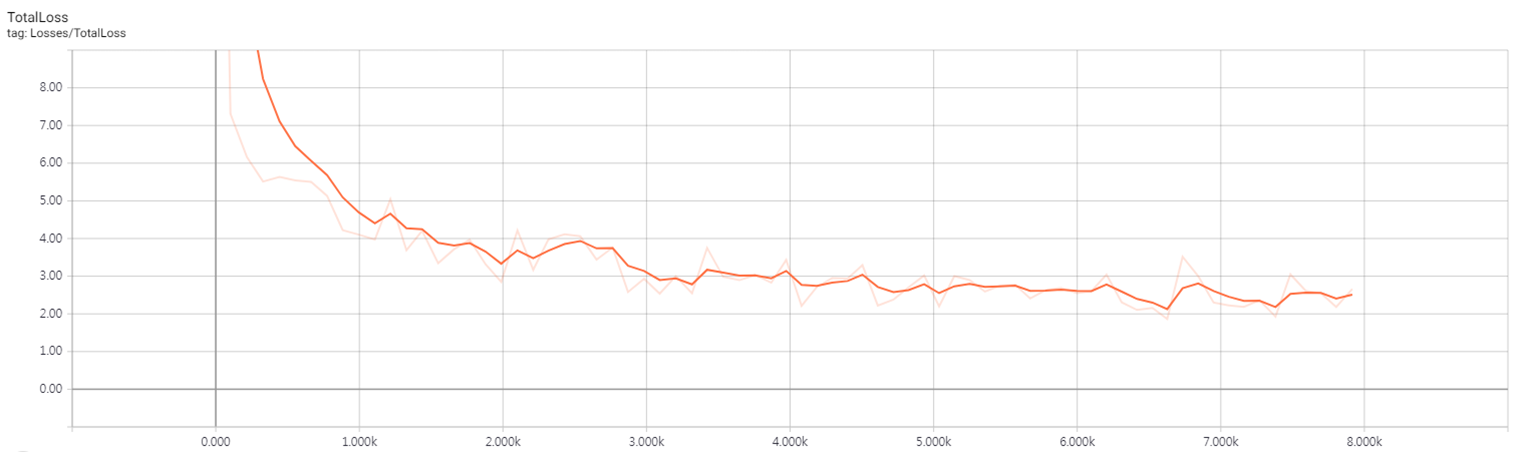

Weight 값이 저장된 PB 파일로 결과물 도출 (Frozen Inference Graph)

# 2. 스쿼트 자세 판별

## 2-1) Import

In [1]:
import numpy as np
import sys
import tensorflow as tf
import cv2 as cv
import time
import paho.mqtt.client as mqtt
sys.path.append("C:/Users/user/Desktop/tensorflowapi/models/research/object_detection")
from utils import label_map_util
from utils import visualization_utils as vis_util
from squat_detection import prepare_training
print("import 완료")

import 완료


## 2-2) 학습 데이터 및 레이블 불러오기 

In [2]:
detection_graph,category_index = prepare_training.get_inference_graph_and_labels(
"frozen_inference_graph100973.pb",'object-detection.pbtxt',5)
print("학습 데이터 및 레이블 불러오기 완료")

학습 데이터 및 레이블 불러오기 완료


## 2-3) Opencv 활용하여 동영상/Webcam 실행

In [3]:
## Webcam/video/image
##################
cap = cv.VideoCapture("squat_vid2_2.mp4")
# cap = cv.VideoCapture(0)
##################
print("OpenCV 비디오 실행 준비 완료")

OpenCV 비디오 실행 준비 완료


## 2-4) Squat 자세 판별

In [4]:
y_value_of_head_before = 1000
flag = True
frame_num = 0

## SQL에 올릴 데이터들
back_error = 0
knee_error = 0
hip_error = 0
success_count = 0
all_squat_count = 0

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:

        classes_dic = {'head': 1, 'knee': 2, 'hip': 3, 'feet': 4, 'back': 5}
        threshold_dic = {'head': 0.2, 'knee': 0.1, 'hip': 0.1, 'feet': 0.2, 'back': 0.05}
        tracker_dic = {}
        points_dic = {}
        detected_dic = {'head': False, 'knee': False, 'hip': False, 'feet': False, 'back': False}
        tracker_points_dic = {}

        while (cap.isOpened()):
            ret, frame = cap.read()
#             frame = np.rot90(frame,3)
            # frame = cv.resize(frame,(600,800))
            frame = frame.copy()
            frame_num += 1

            frame_new_shape = frame.reshape(1,frame.shape[0],frame.shape[1],3)

            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            (boxes, scores, classes, num_detections) = sess.run(
              [boxes, scores, classes, num_detections],
              feed_dict={image_tensor: frame_new_shape})

            rows = frame.shape[0]
            cols = frame.shape[1]

            for i in range(int(num_detections[0])):
                for j in classes_dic.keys():
                    if classes[0][i] == classes_dic[j] and scores[0][i] >= threshold_dic[j] :

                        x = boxes[0][i][1] * cols
                        y = boxes[0][i][0] * rows
                        right = boxes[0][i][3] * cols
                        bottom = boxes[0][i][2] * rows
                        points_dic[j] = [x,y,right,bottom]
                        threshold_dic[j] = min(scores[0][i],0.3)
                        tracker_dic[j] = cv.TrackerMOSSE_create()
                        tracker_dic[j].init(frame, (x, y, right - x, bottom - y))
                        detected_dic[j] = True

            for j in detected_dic.keys():
                if detected_dic[j] == False:
                    if frame_num % 20 == 0:
                        print("not all detected, return to detection")
                    continue


            for keys,values in tracker_dic.items():
                xys = [int(v) for v in values.update(frame)[1]]

                if xys != [0, 0, 0, 0] :
                    tracker_points_dic[keys] = xys

            center_points_dic = {}
            for keys_c,values_c in tracker_points_dic.items():
                center_point = (values_c[0]+round(values_c[2]/2),values_c[1]+round(values_c[3]/2))
                center_points_dic[keys_c] = center_point
                cv.rectangle(frame, (values_c[0], values_c[1]), (values_c[0] + values_c[2], values_c[1] + values_c[3]), (0, 255, 255),
                             thickness=3)
                cv.circle(frame,center_point,5,(0,255,255),thickness=5)



            try :
                slope_hip_knee = (center_points_dic["knee"][1] - center_points_dic["hip"][1]) / \
                                 (center_points_dic["knee"][0] - center_points_dic["hip"][0])
                slope_hip_back = (center_points_dic["hip"][1] - center_points_dic["back"][1]) / \
                                 (center_points_dic["hip"][0] - center_points_dic["back"][0])
                slope_back_head = (center_points_dic["back"][1] - center_points_dic["head"][1]) / \
                                  (center_points_dic["back"][0] - center_points_dic["head"][0])


                ## 올라가는 순간 머리의 y 값이 커지므로, y값이 커지는 시점에 자세를 판별함
                if center_points_dic["head"][1] < y_value_of_head_before and slope_hip_knee < 1 and flag == True :

                    all_squat_count += 1
                    k=0
                    print("가장 내려간 지점 엉덩이와 무릎의 기울기 : ", round(slope_hip_knee, 2))
                    if slope_hip_knee > 0.3:
                        print("엉덩이를 더 내리세요")
                        hip_error += 1
#                         mqttc.publish("hip", "lower hip!!")
                    else :
                        print("엉덩이 ok")
                        k += 1

                    if abs(slope_hip_back - slope_back_head) > 3:
                        print("등을 더 피세요")
                        back_error += 1
#                         mqttc.publish("back", "straighten back")
                    else :
                        print("등 ok")
                        k += 1
                    ## 무릎이 너무 나가있는지 확인

                    if center_points_dic["knee"][0] > tracker_points_dic["feet"][0]+tracker_points_dic["feet"][2] :
                        print("무릎이 발끝 밖으로 나가있는지 확인하세요\n\n")
                        knee_error += 1
#                         mqttc.publish("knee", "keep knee behind feet")

                    else :
                        print("무릎 ok\n\n")
                        k += 1

                    if k == 3:
                        print("올바른 스쿼트 성공!!\n\n")
                        success_count += 1

                    flag = False

                ## 내려가는 순간 머리의 y 값이 작아지므로, y값이 작아지는 시점에 리셋함
                if center_points_dic["head"][1] > y_value_of_head_before :
                    flag = True

                ## 5 프레임전의 y값 저장
                if frame_num % 10 == 0:
                    y_value_of_head_before = center_points_dic["head"][1]
                # slope_hip_knee_frame_before = slope_hip_knee

                mqttc.publish("allsquat", str(all_squat_count))
                mqttc.publish("success", str(success_count))

            except:
                pass




            vis_util.visualize_boxes_and_labels_on_image_array(
              frame,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=5,min_score_thresh=.3)

            cv.imshow('frame',frame)
            k = cv.waitKey(1) & 0xFF

            if  k == ord('q'):
                print("총 스쿼트 한 횟수 : {}, 올바른 자세 : {}".format(all_squat_count,success_count))
                print("이번 스쿼트 세션에서의 범한 오류 허리 : {}, 무릎 : {}, 엉덩이 : {} : "
                      .format(back_error,knee_error,hip_error))
                cv.destroyAllWindows()
                break

            ## threshold 초기화
            elif k == ord("b"):
                threshold_dic = {'head': 0.3, 'knee': 0.3, 'hip': 0.2, 'feet': 0.2, 'back': 0.2}


가장 내려간 지점 엉덩이와 무릎의 기울기 :  0.44
엉덩이를 더 내리세요
등 ok
무릎 ok


가장 내려간 지점 엉덩이와 무릎의 기울기 :  0.19
엉덩이 ok
등 ok
무릎 ok


올바른 스쿼트 성공!!


가장 내려간 지점 엉덩이와 무릎의 기울기 :  0.24
엉덩이 ok
등을 더 피세요
무릎 ok


가장 내려간 지점 엉덩이와 무릎의 기울기 :  0.16
엉덩이 ok
등 ok
무릎 ok


올바른 스쿼트 성공!!


가장 내려간 지점 엉덩이와 무릎의 기울기 :  0.29
엉덩이 ok
등 ok
무릎 ok


올바른 스쿼트 성공!!


총 스쿼트 한 횟수 : 5, 올바른 자세 : 3
이번 스쿼트 세션에서의 범한 오류 허리 : 1, 무릎 : 0, 엉덩이 : 1 : 


# 3. MQTT 응용

## 3-1) 스쿼트 횟수 및 오류 메세지 핸드폰에 출력

In [ ]:
import numpy as np
import sys
import tensorflow as tf
import cv2 as cv
import time
import paho.mqtt.client as mqtt

############################################################################################################################
mqttc = mqtt.Client("python_pub")  # MQTT Client
# mqttc.connect("test.mosquitto.org", 1883)    # MQTT
mqttc.connect("192.168.101.101", 1883)  # iCORE-SDP Broker
############################################################################################################################
sys.path.append("C:/Users/user/Desktop/tensorflowapi/models/research/object_detection")

from utils import label_map_util
from utils import visualization_utils as vis_util


### 이부분 디렉토리 맞춰서 변경해야함
from squat_detection import prepare_training

def main():

    # get inference graph and labels
    detection_graph,category_index = prepare_training.get_inference_graph_and_labels(
        "frozen_inference_graph100973.pb",'object-detection.pbtxt',5)


    ## Webcam/video/image
    ##################
    cap = cv.VideoCapture("squat_vid5_2.mp4")
    # cap = cv.VideoCapture(0)
    ##################

    y_value_of_head_before = 1000
    flag = True
    frame_num = 0

    ## SQL에 올릴 데이터들
    back_error = 0
    knee_error = 0
    hip_error = 0
    success_count = 0
    all_squat_count = 0



    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:

            classes_dic = {'head': 1, 'knee': 2, 'hip': 3, 'feet': 4, 'back': 5}
            threshold_dic = {'head': 0.2, 'knee': 0.1, 'hip': 0.1, 'feet': 0.2, 'back': 0.05}
            tracker_dic = {}
            points_dic = {}
            detected_dic = {'head': False, 'knee': False, 'hip': False, 'feet': False, 'back': False}
            tracker_points_dic = {}

            while (cap.isOpened()):
                ret, frame = cap.read()
                # frame = np.rot90(frame,3)
                # frame = cv.resize(frame,(600,800))
                # frame = frame.copy()
                frame_num += 1

                frame_new_shape = frame.reshape(1,frame.shape[0],frame.shape[1],3)

                image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
                boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
                scores = detection_graph.get_tensor_by_name('detection_scores:0')
                classes = detection_graph.get_tensor_by_name('detection_classes:0')
                num_detections = detection_graph.get_tensor_by_name('num_detections:0')

                (boxes, scores, classes, num_detections) = sess.run(
                  [boxes, scores, classes, num_detections],
                  feed_dict={image_tensor: frame_new_shape})

                rows = frame.shape[0]
                cols = frame.shape[1]

                for i in range(int(num_detections[0])):
                    for j in classes_dic.keys():
                        if classes[0][i] == classes_dic[j] and scores[0][i] >= threshold_dic[j] :

                            x = boxes[0][i][1] * cols
                            y = boxes[0][i][0] * rows
                            right = boxes[0][i][3] * cols
                            bottom = boxes[0][i][2] * rows
                            points_dic[j] = [x,y,right,bottom]
                            threshold_dic[j] = min(scores[0][i],0.3)
                            tracker_dic[j] = cv.TrackerMOSSE_create()
                            tracker_dic[j].init(frame, (x, y, right - x, bottom - y))
                            detected_dic[j] = True

                for j in detected_dic.keys():
                    if detected_dic[j] == False:
                        if frame_num % 20 == 0:
                            print("not all detected, return to detection")
                        continue


                for keys,values in tracker_dic.items():
                    xys = [int(v) for v in values.update(frame)[1]]

                    if xys != [0, 0, 0, 0] :
                        tracker_points_dic[keys] = xys

                center_points_dic = {}
                for keys_c,values_c in tracker_points_dic.items():
                    center_point = (values_c[0]+round(values_c[2]/2),values_c[1]+round(values_c[3]/2))
                    center_points_dic[keys_c] = center_point
                    cv.rectangle(frame, (values_c[0], values_c[1]), (values_c[0] + values_c[2], values_c[1] + values_c[3]), (0, 255, 255),
                                 thickness=3)
                    cv.circle(frame,center_point,5,(0,255,255),thickness=5)



                try :
                    slope_hip_knee = (center_points_dic["knee"][1] - center_points_dic["hip"][1]) / \
                                     (center_points_dic["knee"][0] - center_points_dic["hip"][0])
                    slope_hip_back = (center_points_dic["hip"][1] - center_points_dic["back"][1]) / \
                                     (center_points_dic["hip"][0] - center_points_dic["back"][0])
                    slope_back_head = (center_points_dic["back"][1] - center_points_dic["head"][1]) / \
                                      (center_points_dic["back"][0] - center_points_dic["head"][0])


                    ## 올라가는 순간 머리의 y 값이 커지므로, y값이 커지는 시점에 자세를 판별함
                    if center_points_dic["head"][1] < y_value_of_head_before and slope_hip_knee < 1 and flag == True :

                        all_squat_count += 1
                        k=0
                        print("가장 내려간 지점 엉덩이와 무릎의 기울기 : ", round(slope_hip_knee, 2))
                        if slope_hip_knee > 0.3:
                            print("엉덩이를 더 내리세요")
                            hip_error += 1
############################################################################################################################                            
                            mqttc.publish("hip", "lower hip!!")
############################################################################################################################    
                        else :
                            print("엉덩이 ok")
                            k += 1

                        if abs(slope_hip_back - slope_back_head) > 3:
                            print("등을 더 피세요")
                            back_error += 1
############################################################################################################################                            
                            mqttc.publish("back", "straighten back")
############################################################################################################################    
                        else :
                            print("등 ok")
                            k += 1
                        ## 무릎이 너무 나가있는지 확인

                        if center_points_dic["knee"][0] > tracker_points_dic["feet"][0]+tracker_points_dic["feet"][2] :
                            print("무릎이 발끝 밖으로 나가있는지 확인하세요\n\n")
                            knee_error += 1
############################################################################################################################                            
                            mqttc.publish("knee", "keep knee behind feet")
############################################################################################################################    

                        else :
                            print("무릎 ok\n\n")
                            k += 1

                        if k == 3:
                            print("올바른 스쿼트 성공!!\n\n")
                            success_count += 1

                        flag = False

                    ## 내려가는 순간 머리의 y 값이 작아지므로, y값이 작아지는 시점에 리셋함
                    if center_points_dic["head"][1] > y_value_of_head_before :
                        flag = True

                    ## 5 프레임전의 y값 저장
                    if frame_num % 10 == 0:
                        y_value_of_head_before = center_points_dic["head"][1]
                    # slope_hip_knee_frame_before = slope_hip_knee
############################################################################################################################
                    mqttc.publish("allsquat", str(all_squat_count))
                    mqttc.publish("success", str(success_count))
############################################################################################################################
                except:
                    pass




                vis_util.visualize_boxes_and_labels_on_image_array(
                  frame,
                  np.squeeze(boxes),
                  np.squeeze(classes).astype(np.int32),
                  np.squeeze(scores),
                  category_index,
                  use_normalized_coordinates=True,
                  line_thickness=5,min_score_thresh=.3)

                cv.imshow('frame',frame)
                k = cv.waitKey(1) & 0xFF

                if  k == ord('q'):
                    print("총 스쿼트 한 횟수 : {}, 올바른 자세 : {}".format(all_squat_count,success_count))
                    print("이번 스쿼트 세션에서의 범한 오류 허리 : {}, 무릎 : {}, 엉덩이 : {} : "
                          .format(back_error,knee_error,hip_error))
                    cv.destroyAllWindows()
                    break

                ## threshold 초기화
                elif k == ord("b"):
                    threshold_dic = {'head': 0.3, 'knee': 0.3, 'hip': 0.2, 'feet': 0.2, 'back': 0.2}






main()



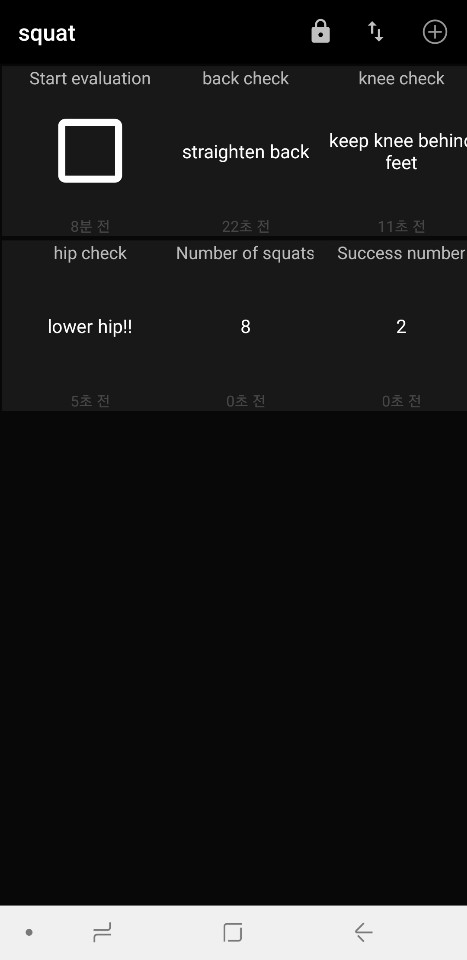

## 3-2) 핸드폰으로 시작하기

In [ ]:
import paho.mqtt.client as mqtt
import squat_trainer_version_0128


def on_connect(client, userdata, flags,rc):
  print ("Connected with result code " + str(rc))
  client.subscribe("hello/world")

def on_message(client, userdata, msg):
  print ("Topic: ", msg.topic + '\nMessage: ' + str(msg.payload))
  buf_str = str(msg.payload.decode())
###################################################
  if buf_str == "1":
    print("야호")
    squat_trainer_version_0128.main()
####################################################

  return buf_str

client = mqtt.Client()        # MQTT Client
client.on_connect = on_connect     # on_connect callback 
# client.on_message = on_message   # on_message callback
client.on_message = on_message

#client.connect("test.mosquitto.org", 1883, 60)   # MQTT 
client.connect("192.168.101.101", 1883, 60)   # iCORE-SDP Broker

client.loop_forever()


## 3-4) 라즈베리파이 또는 스피커를 통해 소리 출력

In [ ]:
import paho.mqtt.client as mqtt
import RPi.GPIO as GPIO
import smbus2 as smbus
import time

GPIO.setmode(GPIO.BCM)
GPIO.setwarnings(False)
buzzer_pin = 13
GPIO.setup(buzzer_pin, GPIO.OUT)

scale = [261,294,329,349,392,440,493,523]
scale2 = [1047,1175,1319,1397,1568,1760,1976,2093]
p = GPIO.PWM(buzzer_pin, 100)
GPIO.output(buzzer_pin, True)

def buzzer_on():
    p.start(100)
    p.ChangeDutyCycle(90)
    
    for i in range(8):
        p.ChangeFrequency(scale[i])
        time.sleep(0.1)
    p.stop()
    
##########################################################
def buzzer_message_control(buf_str):
    if buf_str == "1":
        print("buzzer:",buf_str)
        buzzer_on()
###########################################################
        
        
def on_connect(client, userdata, flags,rc):
    print ("Connected with result code " + str(rc))
    client.subscribe("hello/world")

def on_message(client, userdata, msg):
    print ("Topic: ", msg.topic + '\nMessage: ' + str(msg.payload))
    buf_str = str(msg.payload.decode())
    buzzer_message_control(buf_str)
    

client = mqtt.Client()        # MQTT Client 
client.on_connect = on_connect     # on_connect callback 
client.on_message = on_message   # on_message callback 

#client.connect("test.mosquitto.org", 1883, 60)   # MQTT 
client.connect("localhost", 1883, 60)   # iCORE-SDP Broker 

client.loop_forever()

# 4. SQL / DB 활용

In [ ]:
import csv
import MySQLdb
import sys
import time
import datetime

### 1. ID, 2. 날짜시간분, 3. back_error, 4. knee_error, 5. hip_error, 6. success_count, 7. all_squat_count

## Sql 접속
con = MySQLdb.connect(host='10.1.43.246', port=3306, db='squat_project', user='root', passwd='1234')
c = con.cursor()
con2 = MySQLdb.connect(host='localhost', port=3306, db='squat_project', user='root', passwd='1234')
d = con2.cursor()

## sql로 데이터 추가하기
USER_ID = input('USER_ID? ')
date = datetime.datetime.now().replace(microsecond=0)
back_error = 1
knee_error =5
hip_error=6
success_count=7
all_squat_count = 100

## Sql에 데이터 업로드
data = [('{}'.format(USER_ID), '{}'.format(date), '{}'.format(back_error), '{}'.format(knee_error),'{}'.format(hip_error), '{}'.format(success_count), '{}'.format(all_squat_count))]
segment = 'insert into squat values (%s, %s, %s, %s, %s, %s, %s)'
print(segment,data)
# con.executemany(segment,data)

# con.commit() # 저장


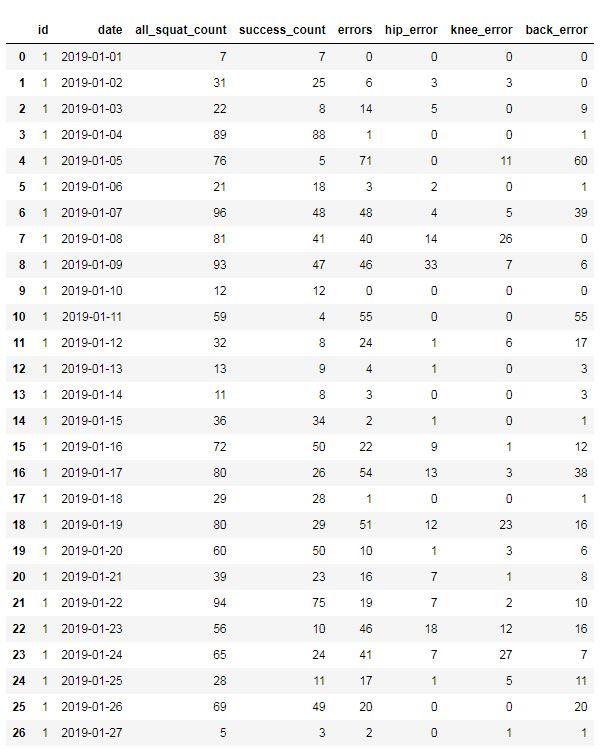

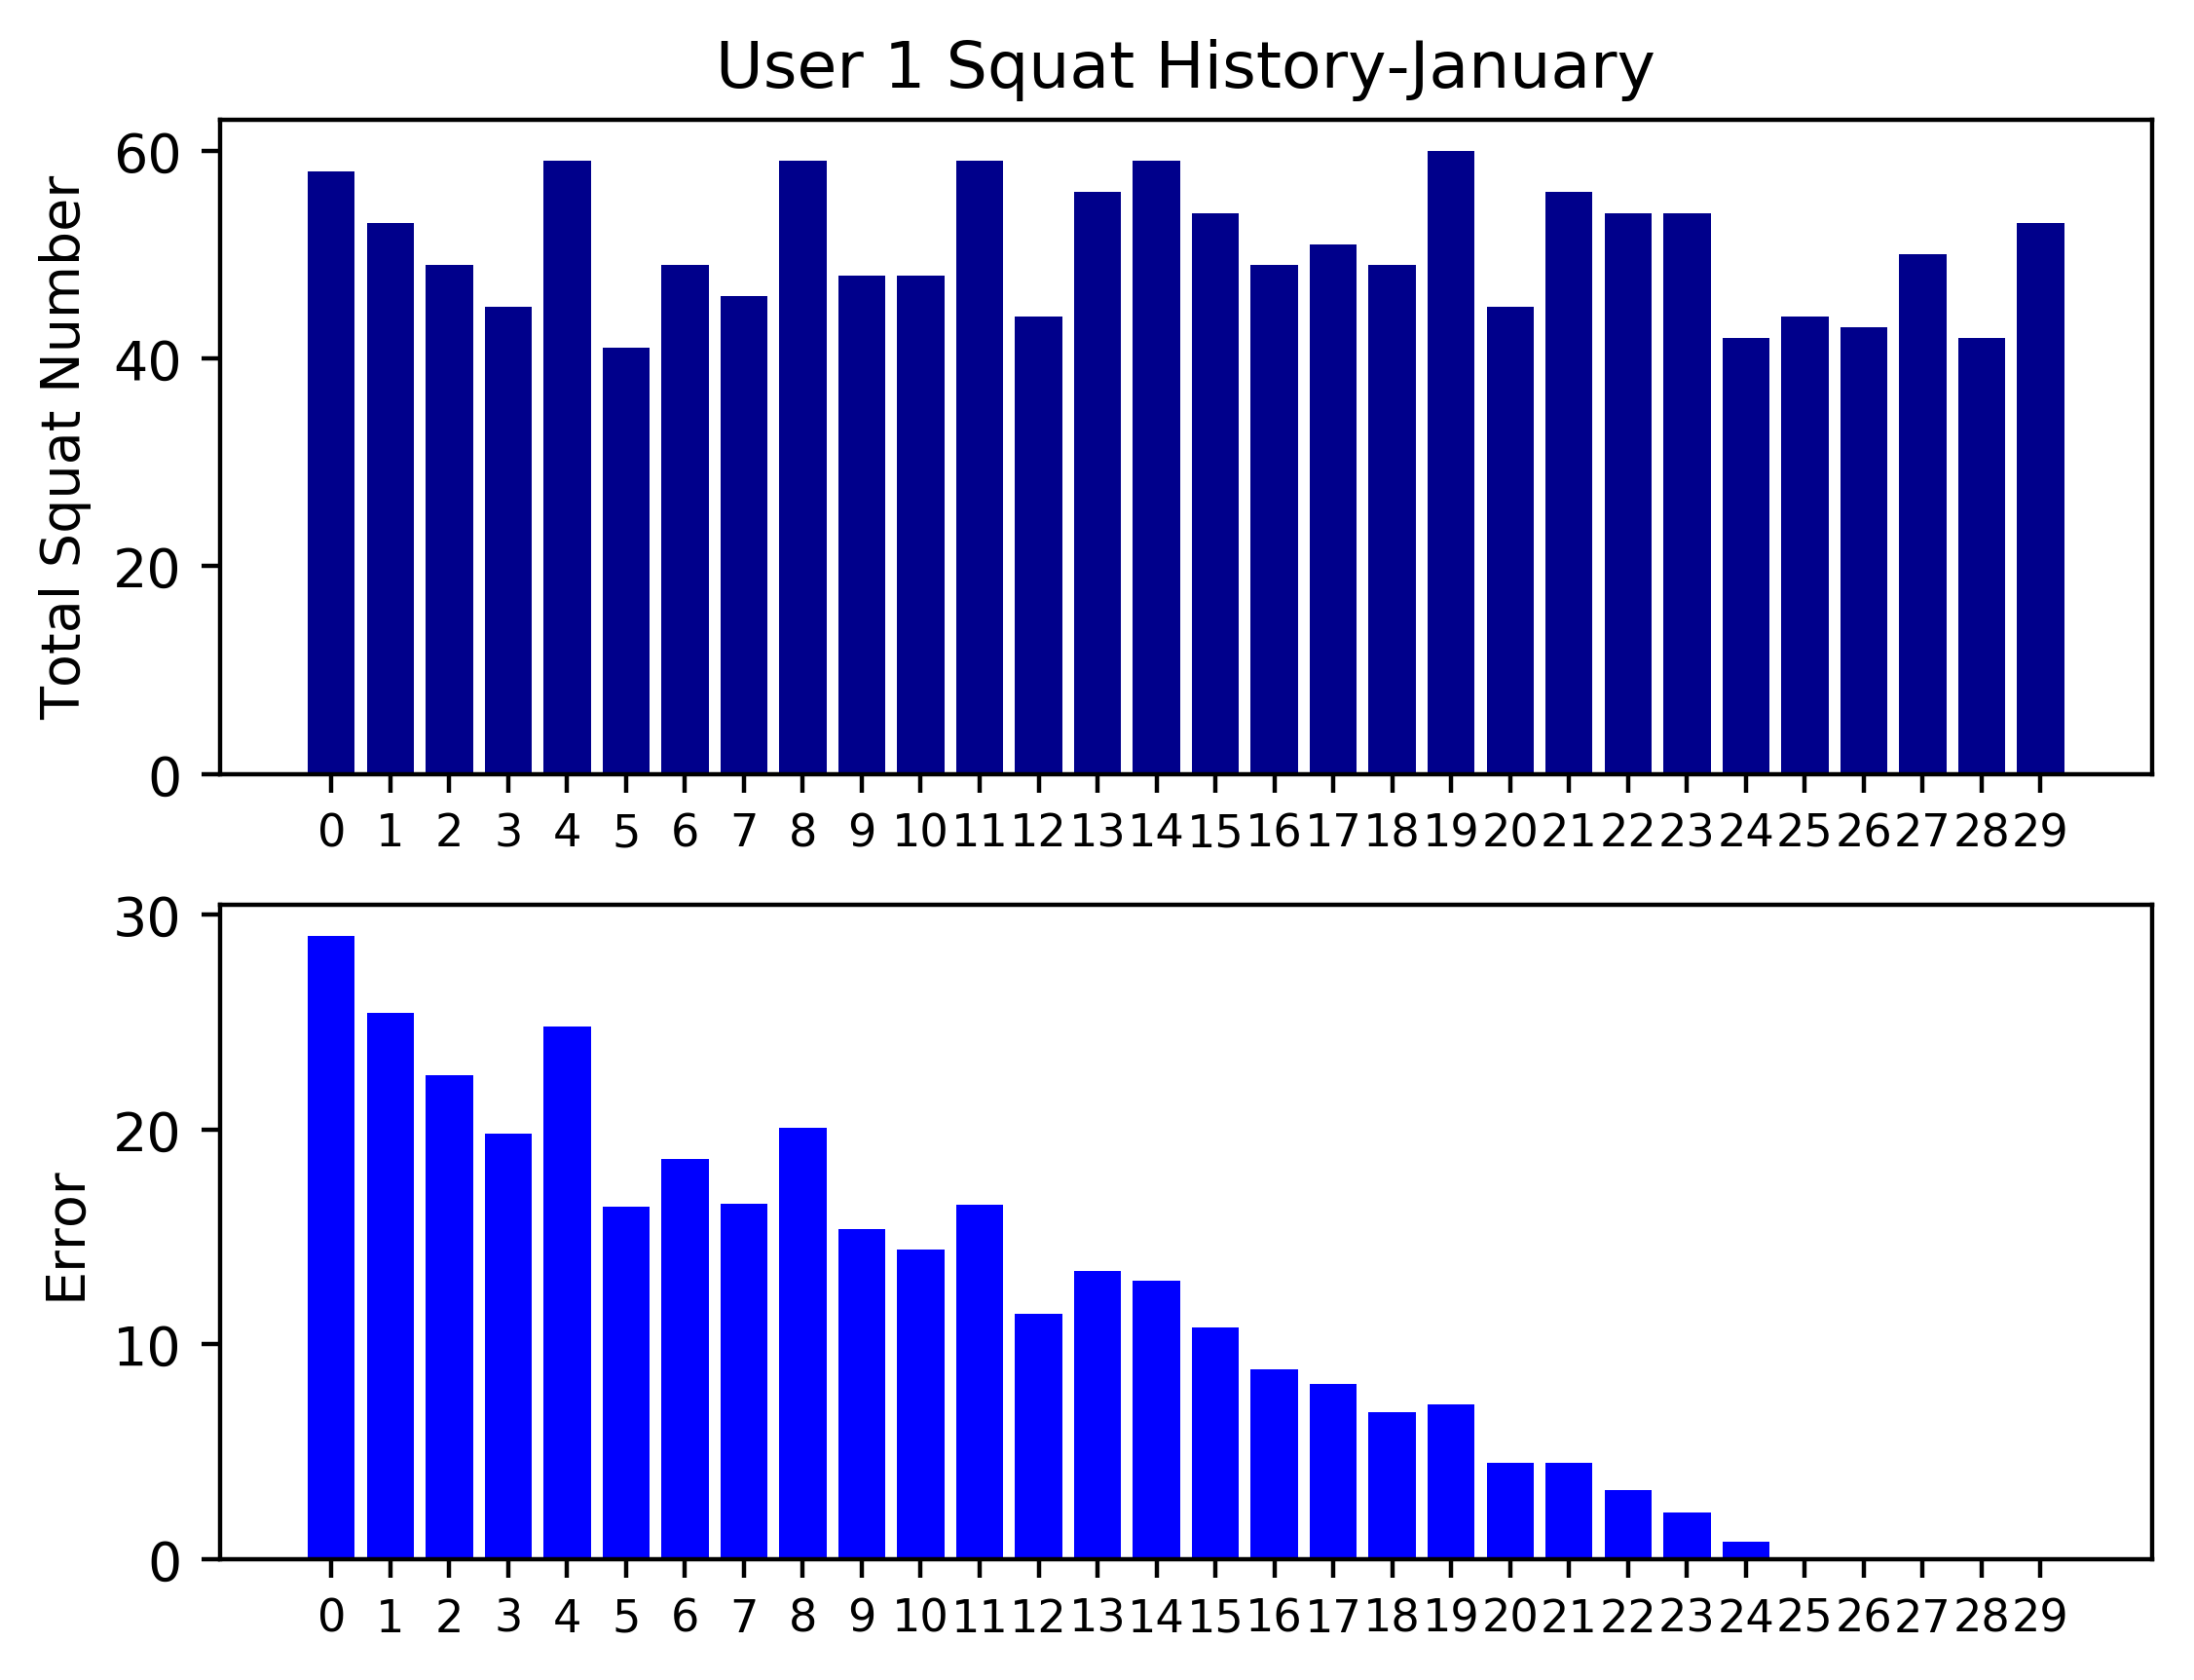

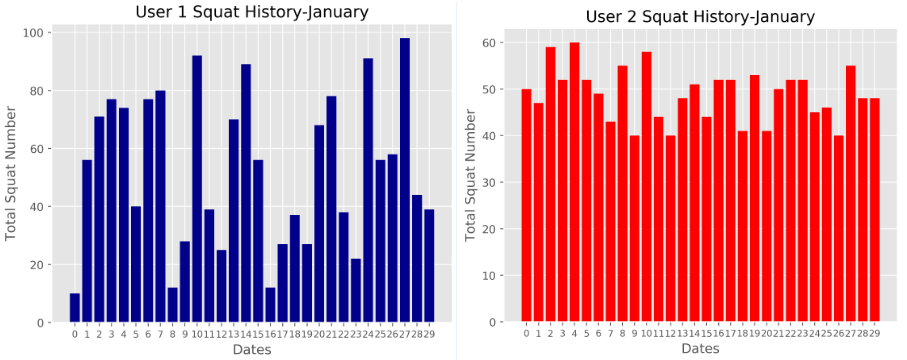

# 5. 개선점

## 1) 학습 과정 이해 부족 => 다양한 모델 활용 미흡
## 2) 라이브러리에 과도한 의존 => 상황에 맞게 응용을 하기 위해선 스스로 코드 작성 필요
## 3) 인식률 개선 필요 => Raw 데이터의 부족 및 학습 위한 설비 필요
## 4) 실활용을 위해서는 앱 개발 능력 필요 => 유저 인터페이스
## 5) 다양한 운동 자세 및 다각도에서 적용 필요

<h1><center>감사합니다</center></h1>